# 05 - Guided GradCAM for CropGuard

## Goals:
- Sharpen GradCAM attention maps using Guided Backpropagation
- Visualize model's pixel-level focus on leaf lesions
- Improve interpretability and transparency for app deployment

# STEP 1: Load Libraries & Model

In [4]:
# Standard Libraries
import os
import sys
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

current_dir = os.getcwd()
print(f"[DEBUG] Current working directory: {current_dir}")

project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"[DEBUG] Project root added to sys.path: {project_root}")

# Internal Project Code
from src.model.architecture import build_model
from src.model.gradcam import GradCAMPlusPlus
from src.data.augment import AugmentationPipeline
from src.data.dataset import PlantVillageDataset
from src.utils.config import BEST_MODEL_PATH, TEST_DIR

[DEBUG] Current working directory: /Users/mitra/vibe_code/CropGuard/notebooks
[DEBUG] Project root added to sys.path: /Users/mitra/vibe_code/CropGuard


In [5]:
# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# Setup transforms
augment = AugmentationPipeline()

# Load Test Dataset
test_ds = PlantVillageDataset(
    root_dir=TEST_DIR,
    transform=augment.get_transforms("val")  # Only normalization
)
print(f"[INFO] Test samples available: {len(test_ds)}")

[INFO] Using device: cpu
[INFO] 3669 images found across 17 classes.
[INFO] Test samples available: 3669


In [6]:
# Build model with correct number of classes
num_classes = len(test_ds.class_to_idx)
model = build_model(num_classes=num_classes, freeze_backbone=False)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model = model.to(device)
model.eval()

print(f"[INFO] Model loaded from {BEST_MODEL_PATH}")

[INFO] Model loaded from /Users/mitra/vibe_code/CropGuard/models/cropguard_best.pt


# STEP 2: Setup helper functions

In [8]:
def unnormalize(img_tensor):
    """
    Unnormalize a tensor image using ImageNet mean and std.
    Returns a NumPy array ready for plotting.
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

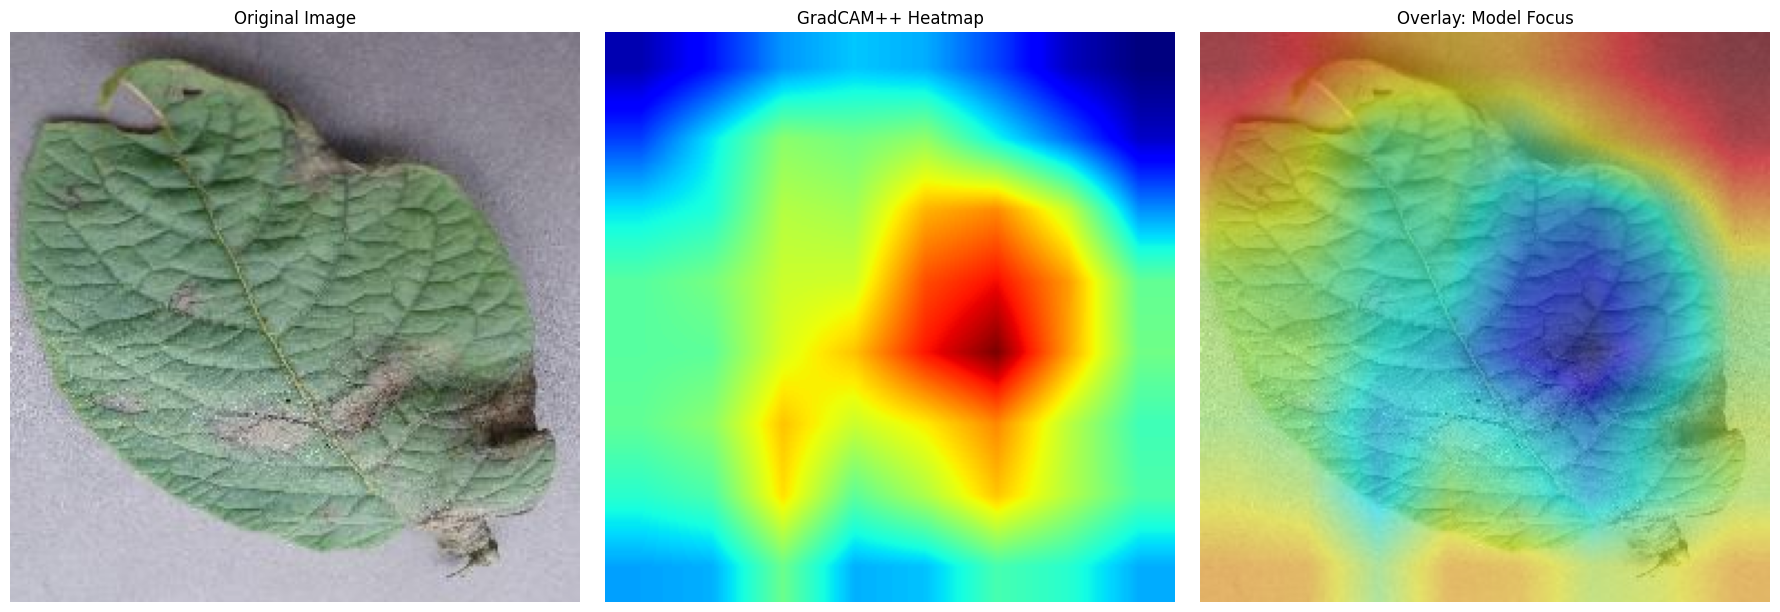

In [17]:
# Pick a random test sample
idx = random.randint(0, len(test_ds)-1)
image, label = test_ds[idx]
input_tensor = image.unsqueeze(0).to(device)

# Choose target layer
target_layer = model.features[-1]  # Last convolution layer

# Initialize GradCAM++
gradcam_pp = GradCAMPlusPlus(model, target_layer)

# Generate heatmap
cam = gradcam_pp.generate(input_tensor)

# Prepare images
img_np = unnormalize(image)
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + img_np
overlay = overlay / np.max(overlay)

# Plot Results
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cam, cmap='jet')
plt.title("GradCAM++ Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay: Model Focus")
plt.axis("off")

plt.tight_layout()
plt.show()

## Summary:

- GradCAM shows that our model focuses intelligently on diseased regions.
- We now have visual interpretability for individual predictions.
- This feature will be integrated into the final application.

#### Next:
- Batch process more test images
- Allow GradCAM visualization inside the app (Streamlit/Gradio)
- Enhance user trust with transparent model behavior